<a href="https://colab.research.google.com/github/victorcharpentier/Anapix/blob/main/VPC_Clustering_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install neptune-client
#!pip install neptune-neptune_pytorch_lightning

NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMDhiZDBkMC1jMjhkLTQ0YjgtYmVlYS02Y2E0ZThmNDY3NjIifQ=="


!pip install pytorch-lightning

#!pip install -U git+https://github.com/albumentations-team/albumentations_experimental


import psutil
import ipywidgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler, SGD

import os

import albumentations as A
from albumentations.pytorch import ToTensor

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning import loggers
from pytorch_lightning.metrics.functional import accuracy, auroc, recall, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import silhouette_score

from collections import OrderedDict

     |████████████████████████████████| 819kB 8.1MB/s 
     |████████████████████████████████| 829kB 41.2MB/s 
     |████████████████████████████████| 235kB 41.0MB/s 
     |████████████████████████████████| 645kB 41.4MB/s 
     |████████████████████████████████| 10.6MB 40.3MB/s 
     |████████████████████████████████| 122kB 58.5MB/s 
     |████████████████████████████████| 1.3MB 34.4MB/s 
     |████████████████████████████████| 296kB 56.6MB/s 
     |████████████████████████████████| 143kB 45.6MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=4dd791d631e4dee5ddd933c4e4b90052523ab926c68da49a273ac12525e6b65a
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/Anapix/

/content/gdrive/My Drive/Anapix


In [4]:
images_path = 'vpc_autocropped_224/'

## Construction des 2 bases de données train et test "concensus" 

Ces dernières servent à entrainer et évaluer le modèle SVM donnant un score un score de ressemblance pour deux images à partir de 2 fois 512 features


In [6]:
data_train = pd.read_csv('train_consensus_yanal.csv')
data_test = pd.read_csv('test_consensus_yanal.csv')
concensus_yanal = pd.concat([data_train, data_test], ignore_index=True)
print(concensus_yanal)

for i in [221,218,180,182,131,39]: #base test

  if i == 221:
    new_test=concensus_yanal[concensus_yanal['patient_id']==i]
  else:
    new_test=pd.concat([new_test, concensus_yanal[concensus_yanal['patient_id']==i]], join='outer')

  concensus_yanal.drop(concensus_yanal[concensus_yanal['patient_id']==i].index, axis=0, inplace=True) #suppression de la base test

new_train=concensus_yanal
new_train.to_csv("new_train_consensus_yanal.csv", index=False)
new_test.to_csv("new_test_consensus_yanal.csv", index=False)


       patient_id       path1        path2  consensus
0             126  P126I1.JPG   P126I1.JPG          9
1             126  P126I1.JPG  P126I10.JPG          0
2             126  P126I1.JPG  P126I11.JPG          0
3             126  P126I1.JPG  P126I12.JPG          0
4             126  P126I1.JPG  P126I13.JPG          0
...           ...         ...          ...        ...
28085          68   P68I9.JPG    P68I5.JPG          3
28086          68   P68I9.JPG    P68I6.JPG          7
28087          68   P68I9.JPG    P68I7.JPG          4
28088          68   P68I9.JPG    P68I8.JPG          8
28089          68   P68I9.JPG    P68I9.JPG          9

[28090 rows x 4 columns]


In [10]:
class ResnetMulti9cl(LightningModule):  #récupération de notre modèle
        def __init__(self, hparams):
          super().__init__()
          self.save_hyperparameters(hparams)
          self.batch_size = hparams['batch_size']
          self.lr = hparams['lr']
          self.workers = hparams['workers']
          self.test_results = []
          self.test_labels = []
          
          self.model = models.resnet50(pretrained=True)
          self.num_features = self.model.fc.in_features
          self.model.fc = torch.nn.Linear(self.num_features, 512)



        def forward_once(self, x):
          output = self.model(x)
          return output
    

        def forward(self, input1, input2):
          output1 = self.forward_once(input1)
          output2 = self.forward_once(input2)
          euclidean_distance = F.pairwise_distance(output1, output2)
          return euclidean_distance

ckpt_path_198_TES_5 = 'siamese/TES-5/checkpoints/epoch=9-step=11739.ckpt'
model_198_TES_5 = ResnetMulti9cl.load_from_checkpoint(checkpoint_path=ckpt_path_198_TES_5)
model_198_TES_5.freeze()  #blocage des neurones aléatoires

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


##Création du jeu de données train avec 1024 features pour la comparaison de 2 images avec 512 features par image et un label expert entre 0 et 1 pour entrainer le SVM

In [14]:
from sklearn.model_selection import cross_val_score
from pandas import DataFrame

model = model_198_TES_5

data_train = pd.read_csv('new_train_consensus_yanal.csv',
index_col=[0,1,2])

data_train.drop(199, axis=0, inplace=True)#enlever le patient 199 car on a pas ses images
X=[]
y=[]

patient_id=0
for index, row in data_train.iterrows():
  if patient_id!=index[0]: #lorsqu'on change de patient
    print("patient_id : "+str(index[0]))
    patient_infos = data_train.loc[index[0]]

    for index1, row in patient_infos.iterrows():
      
        img_name1 = images_path + str(index1[0])
        image1 = cv2.imread(img_name1)
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        image1 = image1/255
        image1 = ToTensor()(image=image1)['image'].float()
        image1 = image1.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle  

        img_name2 = images_path + str(index1[1])
        image2 = cv2.imread(img_name2)
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        image2 = image2/255
        image2 = ToTensor()(image=image2)['image'].float()
        image2 = image2.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle 

        print(img_name1+" + "+img_name2)

        logits1 = model.forward_once(image1)
        logits2= model.forward_once(image2)
        x= torch.cat((logits1, logits2),1)

        features = []
        for k in range(len(x[0])):
          features.append(float(x[0][k]))
        
        X.append(features)
        y.append(row[0]/9)

    patient_id = index[0]

X = DataFrame(X)
X.to_csv('X_train_features_2_images.csv', index=False)

y = DataFrame(y) 
y.to_csv('y_train_features_2_images.csv', index=False)


      



/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I13.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I14.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I15.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I16.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I17.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I18.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I19.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I2.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I20.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I21.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I22.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I23.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I24.JPG
vpc_autocropped_224/P65I30.JPG + vpc_autocropped_224/P65I25.JPG
vpc_autocropped_224/P65I30.

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from joblib import dump
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import mean_absolute_error

X = pd.read_csv('X_train_features_2_images.csv.csv')
print(X.shape)
y = pd.read_csv('y_train_features_2_images.csv.csv')
print(y.shape)

X_test = pd.read_csv('X_test_features_2_images.csv')
print(X_test.shape)
y_test = pd.read_csv('y_test_features_2_images.csv')
print(y_test.shape)

'''C = np.array([10**-3,10**-2,10**-1,1,10,100,1000])
epsilon = np.array([10**-3,10**-2,10**-1,1,10,100,1000])
kernel = np.array(['linear'])#'poly','rbf','sigmoid','precomputed'

param_grid = {"C":C,"epsilon":epsilon,"kernel":kernel}
clf_SVM = svm.SVR()
grid=GridSearchCV(clf_SVM,param_grid, cv=2, n_jobs=4)
grid.fit(X,y)
print(grid.cv_results_)'''


'''for C in np.array([10**-3,10**-2,10**-1,1,10,100,1000]):
  for epsilon in np.array([10**-3,10**-2,10**-1,1,10,100,1000]):
    for kernel in np.array(['linear']): #, 'poly','rbf','sigmoid','precomputed'

      clf_SVM = svm.SVR(kernel=kernel, C=C, epsilon=epsilon)
      print("kernel : "+kernel+" C : "+str(C)+" epsilon : "+str(epsilon))
      print(cross_val_score(clf_SVM, X, y, cv=2, scoring = "neg_mean_absolute_error"))
      print("score SVM sur les données test : "+str(mean_absolute_error(y_test, clf_SVM.predict(X_test))))'''


clf_SVM = svm.SVR()
clf_SVM.fit(X,y)
print(mean_absolute_error(y, clf_SVM.predict(X)))

dump(clf_SVM, 'SVM.joblib')

(24124, 1024)
(24124, 1)
(3710, 1024)
(3710, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.10865866559992571


['SVM.joblib']

In [9]:
from joblib import dump, load

#Télécharger le modèle depuis le fichier
clf_SVM_trained = load('SVM.joblib')

print(clf_SVM_trained)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


##Création du jeu de données test avec 1024 features pour la compraraisons de 2 images avec 512 features par image et un label expert entre 0 et 1 pour évaluer le SVM

In [15]:
from pandas import DataFrame

data_test = pd.read_csv('new_test_consensus_yanal.csv',
index_col=[0,1,2])
model = model_198_TES_5
#data_test.drop(199, axis=0, inplace=True)#enlever le patient 199 car on a pas ses images
X=[]
y=[]

patient_id=0
for index, row in data_test.iterrows():
  if patient_id!=index[0]: #lorsqu'on change de patient
    print("patient_id : "+str(patient_id)+" index : "+str(index[0]))
    patient_infos = data_test.loc[index[0]]

    for index1, row in patient_infos.iterrows():
      
      img_name1 = images_path + index1[0]
      image1 = cv2.imread(img_name1)
      image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
      image1 = image1/255
      image1 = ToTensor()(image=image1)['image'].float()
      image1 = image1.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle  

      img_name2 = images_path + index1[1]
      image2 = cv2.imread(img_name2)
      image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
      image2 = image2/255
      image2 = ToTensor()(image=image2)['image'].float()
      image2 = image2.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle 

      print(img_name1+" + "+img_name2)

      logits1 = model.forward_once(image1)
      logits2= model.forward_once(image2)
      x= torch.cat((logits1, logits2),1)

      features = []
      for k in range(len(x[0])):
        features.append(float(x[0][k]))
        
      X.append(features)
      y.append(row[0]/9)

    patient_id = index[0]
  
X = DataFrame(X) 
X.to_csv('X_test_features_2_images.csv', index=False)

y = DataFrame(y) 
y.to_csv('y_test_features_2_images.csv', index=False)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
vpc_autocropped_224/P41I1.JPG + vpc_autocropped_224/P41I7.JPG
vpc_autocropped_224/P41I1.JPG + vpc_autocropped_224/P41I8.JPG
vpc_autocropped_224/P41I1.JPG + vpc_autocropped_224/P41I9.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I0.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I1.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I10.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I11.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I12.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I13.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I14.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I15.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I16.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I17.JPG
vpc_autocropped_224/P41I10.JPG + vpc_autocropped_224/P41I18.JPG
vpc_autocropped_224/P41I10.JPG + v

In [18]:
from sklearn.metrics import mean_absolute_error

X_test = pd.read_csv('X_test_features_2_images.csv')
print(X_test.shape)
y_test = pd.read_csv('y_test_features_2_images.csv')
print(y_test.shape)

print("score SVM sur les données test : "+str(mean_absolute_error(y_test, clf_SVM_trained.predict(X_test))))

(6130, 1024)
(6130, 1)
score SVM sur les données test : 0.11370605949028705


In [19]:
from sklearn.metrics import mean_squared_error

X_test = pd.read_csv('X_test_features_2_images.csv')
print(X_test.shape)
y_test = pd.read_csv('y_test_features_2_images.csv')
print(y_test.shape)

print("score SVM sur les données test : "+str(mean_squared_error(y_test, clf_SVM_trained.predict(X_test))))

(6130, 1024)
(6130, 1)
score SVM sur les données test : 0.023060928636666964


##Enregistrement du concensus modèle entre images par patient sur la base new_train

In [ ]:
model = model_198_TES_5

data_train = pd.read_csv('new_train_consensus_yanal.csv',
index_col=[0,1,2])

data_train.drop(199, axis=0, inplace=True)#enlever le patient 199 car on a pas ses images

patient_id=0
for index, row in data_train.iterrows():
  if patient_id!=index[0]: #lorsqu'on change de patient
    print("patient_id : "+str(patient_id)+" index : "+str(index[0]))
    patient_infos = data_train.loc[index[0]]
    print(patient_infos)
    patient_id_index=[]
    path1_index=[]
    path2_index=[]
    for index1, row in patient_infos.iterrows():

      patient_id_index.append(index[0])
      path1_index.append(index1[0])
      path2_index.append(index1[1])

      img_name1 = images_path + index1[0]
      image1 = cv2.imread(img_name1)
      image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
      image1 = image1/255
      image1 = ToTensor()(image=image1)['image'].float()
      image1 = image1.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle  

      img_name2 = images_path + index1[1]
      image2 = cv2.imread(img_name2)
      image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
      image2 = image2/255
      image2 = ToTensor()(image=image2)['image'].float()
      image2 = image2.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle 

      x=[]
      logits1 = model.forward_once(image1)
      logits2= model.forward_once(image2)
      x= torch.cat((logits1, logits2),1)

      features = []
      for k in range(len(x[0])):
        features.append(float(x[0][k]))

      prediction = clf_SVM_trained.predict(x)
      if prediction <0:
        prediction=0
      if prediction >1:
        prediction =1
      print(img_name1+" + "+img_name2)

      patient_infos.loc[index1,'concensus']=prediction 

    patient_infos.insert(0,"patient_id",patient_id_index,True)
    patient_infos.insert(1,"path1",path1_index,True)
    patient_infos.insert(2,"path2",path2_index,True)
    patient_infos.set_index(['patient_id','path1','path2'], inplace = True)

    if patient_id == 0:
      data_patients=patient_infos
      print("data_patients")
      print(data_patients)
    else:
      nouveau_patient = patient_infos
      data_patients = pd.concat([data_patients, nouveau_patient], join='outer') #on rajoute les patient au fur et à mesure
      print(data_patients)

  patient_id = index[0] #on change de patient
  print("nouveau patient : "+str(patient_id))

data_patients.to_csv("data_patients_SVM.csv", index=True)
    


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 3

In [7]:
data_patients = pd.read_csv('data_patients_SVM.csv',
index_col=[0,1,2])
print(data_patients)
liste1=[]
liste2=[]
for index, row in data_patients.iterrows():
  if index[0] not in liste1:
    liste1.append(index[0])

patients_train_clustering_par_predicteurs=pd.read_csv('patients_train_clustering_par_predicteurs.csv')
patients_train_clustering_par_predicteurs.set_index('patient_id',inplace=True)

for index1, row1 in patients_train_clustering_par_predicteurs.iterrows():
  if index1 not in liste2:
    liste2.append(index1)

print(liste1)
print(liste2)

                                   consensus  concensus
patient_id path1      path2                            
126        P126I1.JPG P126I1.JPG           9   0.000085
                      P126I10.JPG          0   0.089917
                      P126I11.JPG          0   0.100541
                      P126I12.JPG          0   0.111334
                      P126I13.JPG          0   0.133401
...                                      ...        ...
60         P60I9.JPG  P60I5.JPG            3   0.327452
                      P60I6.JPG            3   0.061761
                      P60I7.JPG            2   0.282216
                      P60I8.JPG            0   0.126818
                      P60I9.JPG            9   0.576234

[24124 rows x 2 columns]
[126, 127, 13, 133, 150, 182, 186, 203, 206, 209, 211, 215, 218, 34, 41, 49, 65, 15, 165, 176, 197, 51, 60]
[13, 15, 26, 34, 41, 49, 51, 60, 65, 68, 126, 127, 133, 150, 165, 176, 186, 197, 203, 206, 209, 211, 215]


In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, inconsistent, fcluster
from pandas import DataFrame

nb_VPC_identifiés_par_cluster_unique=0
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster=0
nb_VPC_total=0
nb_faux_VPC_unique=0
nb_faux_VPC_petit_cluster=0
nb_images=0
nb_testés_total=0

data_patients = pd.read_csv('data_patients_SVM.csv',
index_col=[0,1,2])
print(data_patients)

patient_id=0

patients_train_clustering_par_predicteurs=pd.read_csv('patients_train_clustering_par_predicteurs.csv')
patients_train_clustering_par_predicteurs.set_index('patient_id',inplace=True)

for index, row in data_patients.iterrows():
  if patient_id!=index[0]: #lorsqu'on change de patient
    print("patient_id : "+str(index[0]))
    data_label = patients_train_clustering_par_predicteurs.loc[index[0]]
    Y = DataFrame(data_label['concensus'], columns = ['concensus'])
    Y['concensus'][Y['concensus'] == 0] = "red"
    Y['concensus'][Y['concensus'] != "red"] = "yellow"
    y=[]
    for i ,row in Y.iterrows():
      y.append(row[0])

    nb_images=nb_images+len(y)

    patient_infos = data_patients.loc[index[0]]
    patient = patient_infos.unstack()
    linked = linkage(patient, "centroid")
    
    silhouette_vals=[]

    K = range(3,6) #test de 2 à 5 clusters
    for o in K:
      labels=fcluster(linked, o, "maxclust")
      silhouette_vals.append(np.mean(silhouette_score(patient,labels)))

    idx_max=0
    max=-1
    for k in range(len(silhouette_vals)): #on retrouve le nombre de clusters maximisant la silhouette
      if silhouette_vals[k]>max:
        max=silhouette_vals[k]
        idx_max=k

    prediction = fcluster(linked, idx_max+3, "maxclust")    #l'on utilise le nombre de clusters maximisant la silhouette
    print("la prediction est la suivante : "+str(prediction))

    index_VPC=[]
    nb_testés=0
    nb_clusters=len(np.unique(prediction)) #nombre de clusters dans la prediction
    liste_clusters=[]
    for e in range(nb_clusters):
      liste_clusters.append([])

    for a in range(len(y)):
      if y[a]=="red":
        index_VPC.append(a) #index des VPC
      liste_clusters[prediction[a]-1].append(a) #liste des index par cluster

    print("la liste des clusters est : "+str(liste_clusters))
    print("les index des VPC sont : "+str(index_VPC))
    
    clusters_unique=[]
    for g in range (nb_clusters):
      if len(liste_clusters[g])==1:
        nb_testés=nb_testés+1
        nb_testés_total=nb_testés_total+1
        clusters_unique.append(liste_clusters[g][0]) #on récupère les index de clusters uniques
    
    nb_trouvés_unique=0
    for l in index_VPC:
      if l in clusters_unique:
        nb_trouvés_unique=nb_trouvés_unique+1 #on comptabilise les clusters uniques étant réellement des VPC 
    
    nb_VPC_identifiés_par_cluster_unique=nb_VPC_identifiés_par_cluster_unique + nb_trouvés_unique
    nb_faux_VPC_unique=nb_faux_VPC_unique+len(clusters_unique)-nb_trouvés_unique

    print("Le clustering unique trouve "+str(len(clusters_unique))+ " unique dont "+str(nb_trouvés_unique)+" sur "+str(len(index_VPC))+ " VPC et " + str(len(clusters_unique)-nb_trouvés_unique)+ " faux positifs")

    #dans un second temps on identifie les clusters possédant moins de x d'individus et on regarde le nombre de VPC à l'intérieur

    nb_VPC_total = nb_VPC_total + len(index_VPC)

    nb_trouvés_petit_cluster=0
    nb_cas_petit_cluster=0
    liste_index_petit_clusters=[]
    for r in range(len(liste_clusters)):
      if 1<len(liste_clusters[r])<=3:
        nb_cas_petit_cluster=nb_cas_petit_cluster+len(liste_clusters[r])
        nb_testés=nb_testés+len(liste_clusters[r])
        nb_testés_total=nb_testés_total+len(liste_clusters[r])
        liste_index_petit_clusters.append(r) #on rajoute tout les petits clusters dans une liste
    
    for g in liste_index_petit_clusters:
      for h in liste_clusters[g]:
        if h in index_VPC:          #on regarde s'il y a des VPC dans les petits clusters
          nb_trouvés_petit_cluster=nb_trouvés_petit_cluster+1

    nb_faux_VPC_petit_cluster = nb_faux_VPC_petit_cluster + nb_cas_petit_cluster - nb_trouvés_petit_cluster
    nb_VPC_identifiés_par_cluster_unique_et_petit_cluster = nb_VPC_identifiés_par_cluster_unique_et_petit_cluster + nb_trouvés_unique +nb_trouvés_petit_cluster

    print("Le clustering unique et petits clusters trouve "+str(nb_trouvés_unique+nb_trouvés_petit_cluster)+" VPC sur "+str(len(index_VPC))+ " dont " + str(nb_testés-nb_trouvés_unique-nb_trouvés_petit_cluster)+ " faux positifs")



  patient_id = index[0] #on change de patient

  
rappel_cluster_unique=(nb_VPC_identifiés_par_cluster_unique/nb_VPC_total)*100
precision_cluster_unique=((nb_VPC_identifiés_par_cluster_unique)/(nb_faux_VPC_unique+nb_VPC_identifiés_par_cluster_unique))*100 #définition des scores
f1_cluster_unique=2*(rappel_cluster_unique*precision_cluster_unique)/(rappel_cluster_unique+precision_cluster_unique)

rappel_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/nb_VPC_total)*100
precision_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/(nb_faux_VPC_unique+nb_faux_VPC_petit_cluster+nb_VPC_identifiés_par_cluster_unique_et_petit_cluster))*100
f1__unique_petit_cluster=2*(rappel_unique_petit_cluster*precision_unique_petit_cluster)/(rappel_unique_petit_cluster+precision_unique_petit_cluster)

fp=nb_testés_total-nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
vp=nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
fn=nb_faux_VPC_unique+nb_faux_VPC_petit_cluster
vn=nb_images -fp-vp-fn



print("Pour les clusters uniques, rappel : "+ str(rappel_cluster_unique) + " % précision : "+str(precision_cluster_unique) + " % et f1 = "+str(f1_cluster_unique))
print("Pour les clusters uniques + petit cluster , rappel : "+ str(rappel_unique_petit_cluster) + " % précision : "+str(precision_unique_petit_cluster) + " % et f1 = "+str(f1__unique_petit_cluster))
print("Pour les clusters uniques + petit cluster , spécificité : "+ str((vn)*100/(vn+fp))+ " % ")


                     




                                   consensus  concensus
patient_id path1      path2                            
126        P126I1.JPG P126I1.JPG           9   0.000085
                      P126I10.JPG          0   0.089917
                      P126I11.JPG          0   0.100541
                      P126I12.JPG          0   0.111334
                      P126I13.JPG          0   0.133401
...                                      ...        ...
60         P60I9.JPG  P60I5.JPG            3   0.327452
                      P60I6.JPG            3   0.061761
                      P60I7.JPG            2   0.282216
                      P60I8.JPG            0   0.126818
                      P60I9.JPG            9   0.576234

[24124 rows x 2 columns]
patient_id : 0 index : 126
la prediction est la suivante : [3 1 1 1 1 1 2 2 2 1 2 1 1 1 1 1 1 1]
la liste des clusters est : [[1, 2, 3, 4, 5, 9, 11, 12, 13, 14, 15, 16, 17], [6, 7, 8, 10], [0]]
les index des VPC sont : [0]
Le clustering unique tr

KeyError: ignored

patient_id  path1       path2      
126         P126I1.JPG  P126I1.JPG     0.000085
                        P126I10.JPG    0.089917
                        P126I11.JPG    0.100541
                        P126I12.JPG    0.111334
                        P126I13.JPG    0.133401
                                         ...   
60          P60I9.JPG   P60I5.JPG      0.327452
                        P60I6.JPG      0.061761
                        P60I7.JPG      0.282216
                        P60I8.JPG      0.126818
                        P60I9.JPG      0.576234
Name: concensus, Length: 24124, dtype: float64


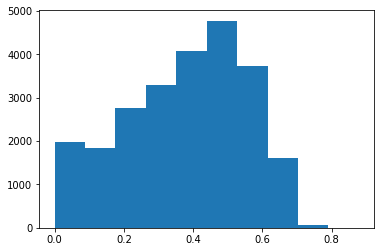

In [10]:
data_patients = pd.read_csv('data_patients.csv',
index_col=[0,1,2])
print(data_patients["concensus"])
plt.hist(data_patients["concensus"])
for index, row in data_patients.iterrows():
  if data_patients.loc[index]["concensus"]<0:

    print(data_patients.loc[index]["concensus"])
